In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import esio

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Load in Obs
data_dir = r'/home/disk/sipn/nicway/data/obs/'
grid_dir = r'/home/disk/sipn/nicway/data/grids/'
fig_dir = r'/home/disk/sipn/nicway/public_html/sipn'
da_81 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0081/sipn_nc/NSIDC_0081.nc'))

In [4]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [5]:
da_81reg = esio.agg_by_domain(da_grid=da_81, ds_region=ds_region)

In [27]:
# Get date 30 days ago
ctime = np.datetime64(datetime.datetime.now())
lag_time_30days = ctime - np.timedelta64(30, 'D')
lag_time_90days = ctime - np.timedelta64(90, 'D')
last_sept = esio.get_season_start_date(ctime)

In [21]:
# Select recent period
da_81 = da_81.where(da_81.time >= lag_time_30days, drop=True)

In [22]:
# Aggregate over domain
da_81_avg = da_81.sum(dim='x').sum(dim='y')*(25*25)/(10**6)

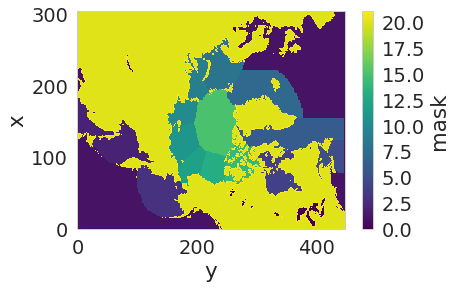

In [26]:
ds_region.mask.plot()

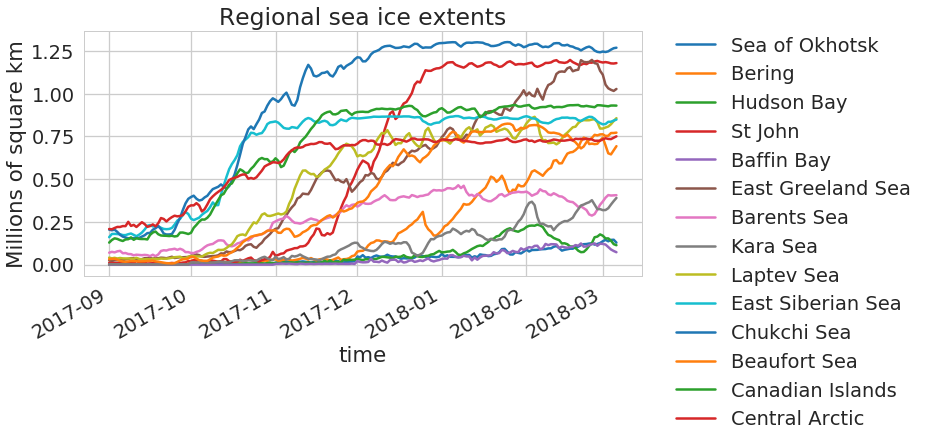

In [48]:
# Plot regional sea ice extents (last 90 days)
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
for cd in da_81reg.nregions:
    da_81reg.where(da_81reg.time >= last_sept, 
                   drop=True).sel(nregions=cd).plot(label=da_81reg.region_names.sel(nregions=cd).values)
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Regional_CurrentSeason.png'),bbox_inches='tight',dpi=200)

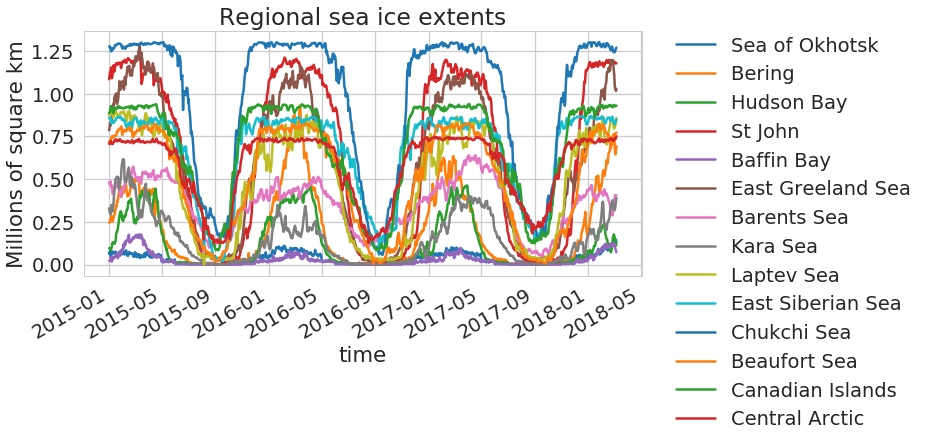

In [24]:
# Plot regional sea ice extents (full time period)
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
for cd in da_81reg.nregions:
    da_81reg.sel(nregions=cd).plot(label=da_81reg.region_names.sel(nregions=cd).values)
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Regional_Full.png'),bbox_inches='tight',dpi=200)

In [10]:
# def plot_model_ensm(ds=None, axin=None, labelin=None, color='grey'):
#     labeled = False
#     for e in ds.ensemble:
#         for it in ds.init_time:
#             if labeled:
#                 labelin = '_nolegend_'
#             axin.plot(ds.fore_time.sel(init_time=it), 
#                       ds.sel(ensemble=e).sel(init_time=it), label=labelin, color=color)
#             labeled = True

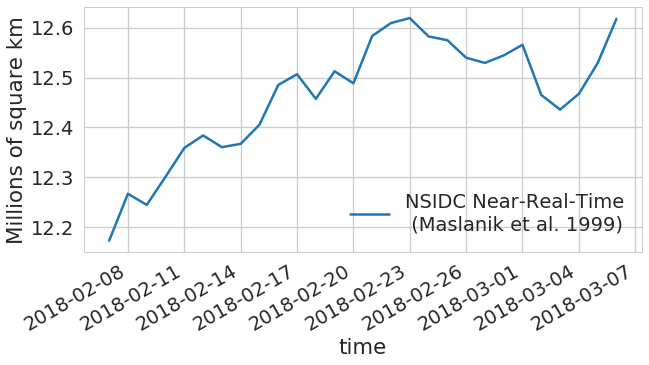

In [11]:
# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
da_81_avg.plot(ax=ax1, label='NSIDC Near-Real-Time\n (Maslanik et al. 1999)')
ax1.set_ylabel('Millions of square km')
# Models
# plot_model_ensm(ds_gfdl_flor_avg, axin=ax1, labelin='GFDL FLORB01 Model Ensembles')
plt.legend(loc='lower right') #bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast.png'),bbox_inches='tight',dpi=200)

In [12]:
# # Plot difference between NSIDC Historical and NRT data set
# plt.figure(figsize=(10,5))
# (da_51_avg-da_81_avg).plot(label='NSIDC Historical - Near Real Time')
# plt.ylabel('Millions of square km')
# plt.legend(bbox_to_anchor=(1.03, 1.05))

In [13]:
# # Plot pan-Arctic sea ice extent RATE (daily)
# f=plt.figure(figsize=(20,10))
# da_51_avg.diff(dim='time').plot(label='NSIDC Historical (Cavalieri et al. 1996)')
# da_79_avg.diff(dim='time').plot(label='NSIDC Bootstrap (Comiso et al. 2017)')
# da_81_avg.diff(dim='time').plot(label='NSIDC Near-Real-Time (Maslanik et al. 1999)')
# plt.ylabel('Millions of square km\n per day')
# plt.legend(bbox_to_anchor=(1.03, 1.05))
# plt.ylim([-0.4, 0.4])
# f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

In [14]:
# # Plot difference between NSIDC Historical and NRT data set RATES
# plt.figure(figsize=(10,5))
# (da_51_avg.diff(dim='time')-da_81_avg.diff(dim='time')).plot(label='NSIDC Historical - Near Real Time')
# plt.ylabel('Millions of square km')
# plt.legend(bbox_to_anchor=(1.03, 1.05))
# plt.ylim([-0.1, 0.1])

In [15]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')
cmap_dif = matplotlib.colors.ListedColormap(sns.color_palette("RdBu", 10))
cmap_dif.set_bad(color = 'lightgrey')


In [16]:
# # Plot coverage on a certain date
# c_sic = ds_gfdl_flor.isel(fore_time_i=0).load()
# c_sic = c_sic.mean(dim='ensemble').sel(init_time=ctime, method='nearest').sic.squeeze()
# c_sic

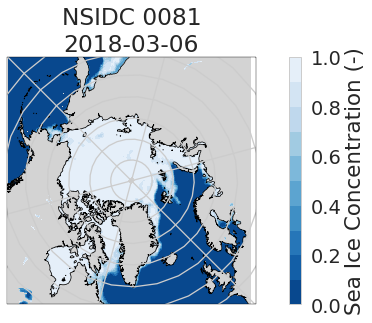

In [17]:
# Plot Obs and model SIC for date
(f, ax1) = esio.polar_axis()
f.set_size_inches(10, 5)
# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
obs1.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('NSIDC 0081\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map.png'),bbox_inches='tight',dpi=200)

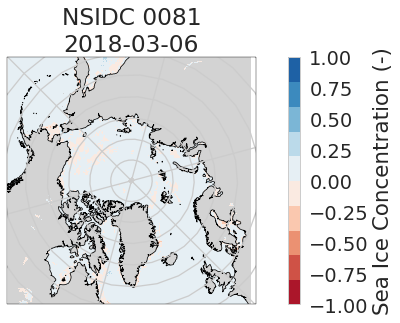

In [18]:
# Plot obs change from yesterday
(f, ax1) = esio.polar_axis()
f.set_size_inches(10, 5)

# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(1, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('NSIDC 0081\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_1Day_Change.png'),bbox_inches='tight',dpi=200)

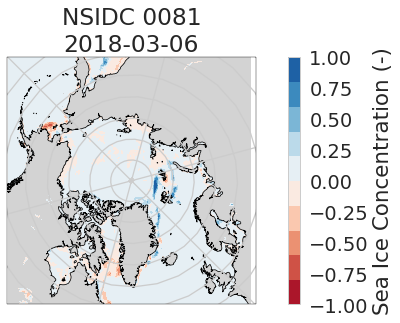

In [19]:
# Plot obs change from last week
(f, ax1) = esio.polar_axis()
f.set_size_inches(10, 5)

# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(7, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('NSIDC 0081\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_1Week_Change.png'),bbox_inches='tight',dpi=200)